# Check Gene - AML Hierarchy 

In [40]:
import sys 
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R -w 8 -h 4 --units in -r 200
library(tidyverse)
library(ggpubr)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [30]:
# load fractions
def load_fractions(dem_path):
    # load CIBERSORT output
    dat = sc.read_csv(dem_path, first_column_names=True)
    dat = dat[:,~dat.var_names.isin(['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)'])]
    dat.obs.index.rename('Sample', inplace=True)

    # Absolute Scores
    absolute_scores = dat.to_df()
    absolute_scores.columns = absolute_scores.columns+'-Absolute'
    dat.obs = dat.obs.merge(absolute_scores, how = 'left', left_index=True, right_index=True)
    
    # Relative Scores (tumor only)
    relative_scores = dat.to_df()
    relative_scores = relative_scores.iloc[:,~relative_scores.columns.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    relative_scores = (relative_scores.transpose() / relative_scores.sum(axis=1).transpose()).transpose()
    relative_scores.columns = relative_scores.columns+'-Relative'
    dat.obs = dat.obs.merge(relative_scores, how = 'left', left_index=True, right_index=True)
    
    return dat

## BEAT-AML

In [28]:
# load the reference cohorts
href = sc.read_h5ad("Data/Hierarchy_Reference_3Cohorts.h5ad")
href.obs = href.obs.join(href.to_df())

# Get drug response data (AUC)
drug_responses = pd.read_csv("Data/Fig4_DrugResponse_LinClass7/BEAT_AML_DrugResponses.csv")
beat_drug = href[href.obs['Cohort'] == "BEAT"]
drug_responses = drug_responses[drug_responses.lab_id.isin(beat_drug.obs.index.values)].drop(columns=['ic50', 'family']).pivot(index='lab_id', columns='inhibitor', values='auc')

# combine into new anndata object with drug response
beat_drug = ad.AnnData(X = drug_responses, obs = beat_drug[beat_drug.obs.index.isin(drug_responses.index.values)].obs)


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
def drug_obs_correlations(adata, obs):

    correlations = pd.DataFrame(columns=['pearson', 'pvalue'])

    for drug in adata.var_names:
        temp = pd.DataFrame({'score' : adata.obs[obs], 'auc' : adata[:,adata.var_names == drug].X.toarray().flatten()}).dropna()
        data = pd.DataFrame(np.asarray(scipy.stats.pearsonr(temp['score'], temp['auc'])), index=['pearson', 'pvalue'], columns=[drug]).T
        correlations = correlations.append(data)

    #correlations['qvalue'] = multitest.multipletests(correlations.pvalue, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    correlations.index.name = "Drug"

    return(correlations)

In [9]:
%%capture 

# Determine correlations between cell types and drug sensitivity (AUC)
df = pd.DataFrame()
for celltype in ['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']:
    temp = drug_obs_correlations(beat_drug, celltype)
    temp['CellType'] = celltype
    df = df.append(temp)

In [10]:
# Perform multiple testing correction and identify significant cell - drug relationships

from statsmodels.stats import multitest
df['qvalue'] = multitest.multipletests(df.pvalue, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
# significantly sensitive at pval < 0.05 and pearson < -0.25
sensitive_drugs = set(df[(df['pvalue'] < 0.05) & (df['pearson'] < -0.25)].index.values)

df['logFDR'] = np.log10(df['qvalue'])
df['CellType'] = df['CellType'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])

In [11]:
# filter matrices for significant drugs
df_pearson = df[df.index.isin(sensitive_drugs)].pivot(columns='CellType', values='pearson').T
df_logFDR = df[df.index.isin(sensitive_drugs)].pivot(columns='CellType', values='logFDR').T
df_qvalue = df[df.index.isin(sensitive_drugs)].pivot(columns='CellType', values='qvalue').T
df_pvalue = df[df.index.isin(sensitive_drugs)].pivot(columns='CellType', values='pvalue').T

In [12]:
# reorder drugs by first Principal component
df_pearson_clust = ad.AnnData(df_pearson).T
sc.pp.pca(df_pearson_clust, n_comps=1)
df_pearson_clust.obs['pc1'] = df_pearson_clust.obsm['X_pca'].flatten()
df_pearson = df_pearson[df_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
df_logFDR = df_logFDR[df_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
df_qvalue = df_qvalue[df_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
df_pvalue = df_pvalue[df_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]

df_pearson = df_pearson * (df_pvalue < 0.05)

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


R[write to console]: corrplot 0.90 loaded



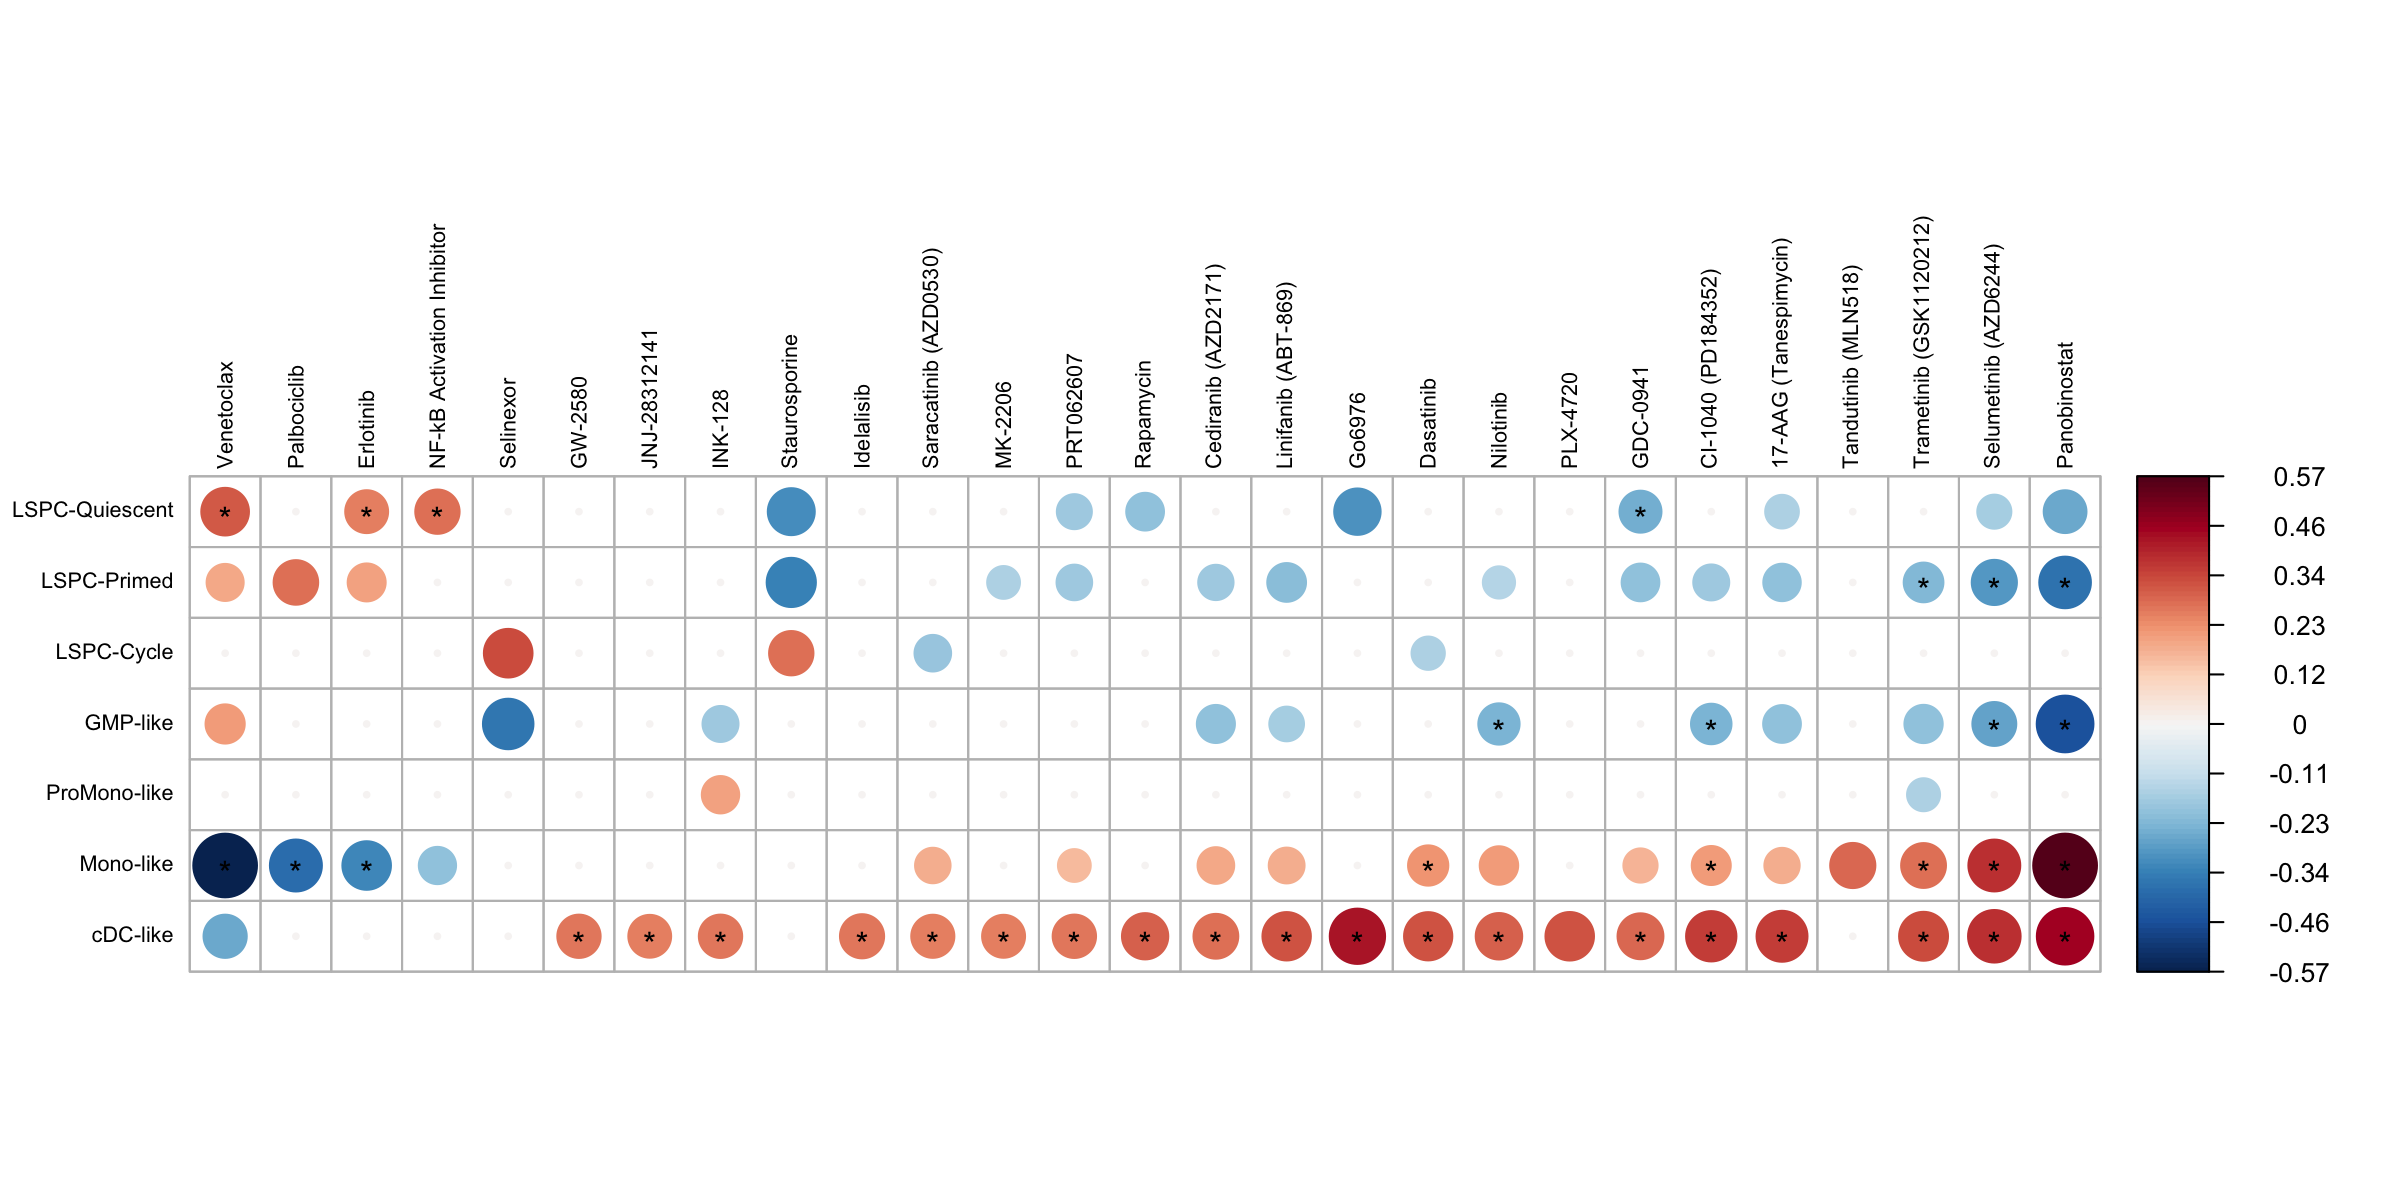

In [13]:
%%R -w 12 -h 6 --units in -r 200 -i df_pearson -i df_logFDR -i df_qvalue -i df_pvalue

library("corrplot")
library(RColorBrewer)

colors <- colorRampPalette(rev(brewer.pal(15, 'RdBu')))
rdbu_continuous <- colors(100)

-df_pearson %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.65, p.mat = data.matrix(df_qvalue),
                                        sig.level=0.05, insig = "label_sig", pch.col = "black", pch.cex = 1, 
                                        is.corr = FALSE, tl.col = 'black', col=rdbu_continuous, cl.lim = c(-0.75, 0.75)) #c("pch", "p-value", "blank", "n", "label_sig"),) 

#df_pearson %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.6, p.mat = data.matrix(df_pvalue),
#                                       sig.level=0.05, insig = "blank", pch.col = "black", pch.cex = 1, 
#                                       is.corr = FALSE, tl.col = 'black') #c("pch", "p-value", "blank", "n", "label_sig"),) 


## Drug Sensitivity correlation with PC1 and PC2

In [15]:
from statsmodels.stats import multitest

def drug_obs_correlations_pearson(adata, obs):

    correlations = pd.DataFrame(columns=['pearson', 'pvalue'])

    for drug in adata.var_names:
        temp = pd.DataFrame({'score' : adata.obs[obs], 'auc' : adata[:,adata.var_names == drug].X.toarray().flatten()}).dropna()
        data = pd.DataFrame(np.asarray(scipy.stats.pearsonr(temp['score'], temp['auc'])), index=['pearson', 'pvalue'], columns=[drug]).T
        correlations = correlations.append(data)

    correlations['qvalue'] = multitest.multipletests(correlations.pvalue, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    correlations.index.name = "Drug"
    correlations['score'] = obs

    return(correlations.sort_values('pvalue'))

In [16]:
%%capture --no-display

beat_scores = drug_obs_correlations_pearson(beat_drug, 'PC1')
beat_scores = beat_scores.append(drug_obs_correlations_pearson(beat_drug, 'PC2'))

beat_scores['-log10(pvalue)'] = -np.log10(beat_scores['pvalue'])
beat_scores['-log10(FDR)'] = -np.log10(beat_scores['qvalue'])
beat_scores['|pearson|'] = np.abs(beat_scores['pearson'])

In [17]:
drug_beat = beat_scores.reset_index()
drug_beat['Drug'] = [x[0] for x in drug_beat['Drug'].str.split(' \(')]

In [18]:
%%R -i drug_beat -w 9.7 -h 8 --units in

library(tidyverse)
library(EnhancedVolcano)

scores <- drug_beat %>% filter(score == 'PC2')

keyvals <- ifelse((scores$pearson > 0.25) & (scores$qvalue < 0.05), 'red',
      ifelse((scores$pearson < -0.25) & (scores$qvalue < 0.05), 'blue', 'black'))
keyvals[is.na(keyvals)] <- 'black'
names(keyvals)[keyvals == 'red'] <- '\nTargets Primitive Blasts\n'
names(keyvals)[keyvals == 'black'] <- '\nN.S.\n'
names(keyvals)[keyvals == 'blue'] <- '\nTargets Mature Blasts\n'

p <- scores %>% 
    mutate(pearson = pearson) %>% 
    EnhancedVolcano(
        lab = scores$Drug,labSize = 5,
        #selectLab = names,labSize = 4,
        x = 'pearson', xlab = 'Correlation with Drug Sensitivity',
        y = 'qvalue', ylab = expression('-Log'[10]*'FDR'),
        colCustom = keyvals,
        drawConnectors = TRUE, 
        xlim = c(-0.6, 0.6), ylim = c(0,8),
        pCutoff = 0.05, FCcutoff = 0.25, 
        cutoffLineWidth = 0.15,
        gridlines.major = FALSE,
        gridlines.minor = FALSE,
        title = "PC2 (Stem vs Mature)",
        subtitle = "Correlation with Drug Sensitivity (-AUC)",
        legendPosition = 'right')
    
p

R[write to console]: Error in library(EnhancedVolcano) : 
  there is no package called ‘EnhancedVolcano’

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In brewer.pal(15, "RdBu") :
R[write to console]: 
 
R[write to console]:  n too large, allowed maximum for palette RdBu is 11
Returning the palette you asked for with that many colors


R[write to console]: 2: 
R[write to console]: In text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt,  :
R[write to console]: 
 
R[write to console]:  "cl.lim" is not a graphical parameter

R[write to console]: 3: 
R[write to console]: In text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col,  :
R[write to console]: 
 
R[write to console]:  "cl.lim" is not a graphical parameter

R[write to console]: 4: 
R[write to console]: In title(title, ...) :
R[write to console]:  "cl.lim" is not a graphical parameter




Error in library(EnhancedVolcano) : 
  there is no package called ‘EnhancedVolcano’


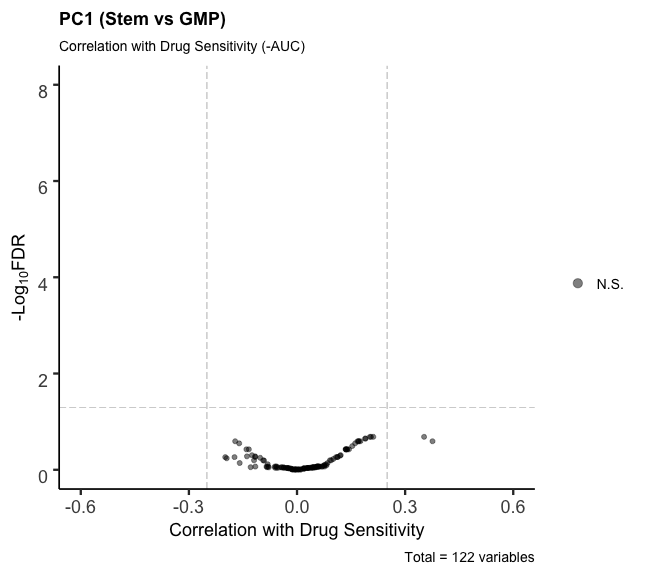

In [54]:
%%R -i drug_beat -w 9 -h 8 --units in

library(tidyverse)
library(EnhancedVolcano)

#names <- c('Tipifarnib', 'BAY 11-7082', 'Azacitidine', 'Mubritinib', 'BAY 11-7085', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Fenretinide', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')
#names <- c('Tipifarnib', 'Azacitidine', 'Mubritinib', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')

scores <- drug_beat %>% filter(score == 'PC1')

keyvals <- ifelse((scores$pearson > 0.25) & (scores$qvalue < 0.05), 'red',
      ifelse((scores$pearson < -0.25) & (scores$qvalue < 0.05), 'blue', 'black'))
keyvals[is.na(keyvals)] <- 'black'
names(keyvals)[keyvals == 'red'] <- '\nTargeting\nPrimitive Blasts\n'
names(keyvals)[keyvals == 'black'] <- '\nN.S.\n'
names(keyvals)[keyvals == 'blue'] <- '\nTargeting\nMature Blasts\n'

p <- scores %>% 
    mutate(pearson = pearson) %>% 
    EnhancedVolcano(
        lab = scores$Drug,labSize = 5,
        #selectLab = names,labSize = 4,
        x = 'pearson', xlab = 'Correlation with Drug Sensitivity',
        y = 'qvalue', ylab = expression('-Log'[10]*'FDR'),
        colCustom = keyvals,
        drawConnectors = TRUE, 
        xlim = c(-0.6, 0.6), ylim = c(0,8),
        pCutoff = 0.05, FCcutoff = 0.25, 
        cutoffLineWidth = 0.15,
        gridlines.major = FALSE,
        gridlines.minor = FALSE,
        title = "PC1 (Stem vs GMP)",
        subtitle = "Correlation with Drug Sensitivity (-AUC)",
        legendPosition = 'right')
    
p

## Additional Dataset - 14 refractory AMLs from Lee et al 2018

In [31]:
drugRefract = load_fractions("Data/Fig4_DrugResponse_LinClass7/CIBERSORTx_Results_Lee2018_14refract_DrugScreen.csv")
# Collapse technical replicates
dat = drugRefract.to_df()
dat.index = [x[1] for x in dat.index.str.replace("R", "").str.split('_')]
dat = dat.reset_index().groupby('index').sum()/2
drugRefract = ad.AnnData(dat)
drugRefract

AnnData object with n_obs × n_vars = 12 × 14

In [32]:
# Filter for malignant
drugRefract = drugRefract[:,['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']]
# Get Absolute Scores
temp = drugRefract.to_df()
temp.columns = temp.columns+'-Absolute'
drugRefract.obs = drugRefract.obs.join(temp)
# Get Relative Scores
drugRefract.X = (drugRefract.X.transpose() / drugRefract.X.sum(axis=1)).transpose()
temp = drugRefract.to_df()
temp.columns = temp.columns+'-Relative'
drugRefract.obs = drugRefract.obs.join(temp)

drugRefract.obs

,LSPC-Quiescent-Absolute,LSPC-Primed-Absolute,LSPC-Cycle-Absolute,GMP-like-Absolute,ProMono-like-Absolute,Mono-like-Absolute,cDC-like-Absolute,LSPC-Quiescent-Relative,LSPC-Primed-Relative,LSPC-Cycle-Relative,GMP-like-Relative,ProMono-like-Relative,Mono-like-Relative,cDC-like-Relative
index,,,,,,,,,,,,,,
AML182,1.373967,0.164263,0.360760,1.102804,0.165811,0.000000,1.013257,0.328633,0.039289,0.086289,0.263774,0.039659,0.000000,0.242356
AML185,0.112511,0.038173,2.165045,1.060968,0.514176,0.000000,1.157742,0.022286,0.007561,0.428839,0.210150,0.101845,0.000000,0.229319
AML186,1.879735,0.317757,0.027267,1.083710,0.104110,0.000000,1.963557,0.349644,0.059105,0.005072,0.201578,0.019365,0.000000,0.365236
AML187,1.201259,0.509263,0.115558,0.060215,0.575736,0.000000,2.411693,0.246477,0.104492,0.023710,0.012355,0.118131,0.000000,0.494836
AML188,1.523986,0.141556,1.679936,0.278562,0.030972,0.000000,0.939133,0.331723,0.030812,0.365669,0.060634,0.006742,0.000000,0.204420
AML190,1.435187,0.459388,1.845709,0.017968,0.105814,0.000000,0.698704,0.314543,0.100682,0.404515,0.003938,0.023191,0.000000,0.153132
AML191,0.824776,0.593821,0.847952,1.816443,0.262314,0.000000,1.345774,0.144924,0.104342,0.148997,0.319174,0.046092,0.000000,0.236471
AML192,1.078522,0.839210,0.791808,0.015173,0.018697,2.584761,2.953713,0.130227,0.101331,0.095607,0.001832,0.002258,0.312098,0.356648
AML197,0.939593,0.973625,1.578031,0.495228,0.045510,0.000000,1.203815,0.179455,0.185955,0.301392,0.094585,0.008692,0.000000,0.229920


### Get AUC

In [33]:
Refract_AUC = sc.read_csv("../../../CIBERSORT/newDataSets_Jul2020/Lee2018_Drugscreen/Lee2018_14ptx_refract_drugAUC.csv").T
Refract_AUC.obs = drugRefract.obs
Refract_AUC

AnnData object with n_obs × n_vars = 12 × 156
    obs: 'LSPC-Quiescent-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Cycle-Absolute', 'GMP-like-Absolute', 'ProMono-like-Absolute', 'Mono-like-Absolute', 'cDC-like-Absolute', 'LSPC-Quiescent-Relative', 'LSPC-Primed-Relative', 'LSPC-Cycle-Relative', 'GMP-like-Relative', 'ProMono-like-Relative', 'Mono-like-Relative', 'cDC-like-Relative'

In [34]:
# Relative correlations
relcorr = pd.DataFrame()
for celltype in Refract_AUC.obs.columns[Refract_AUC.obs.columns.str.contains("-Relative")]:
    temp = drug_obs_correlations(Refract_AUC, celltype)
    temp['CellType'] = celltype.replace('-Relative', '')
    relcorr = relcorr.append(temp)
    
relcorr['qvalue'] = multitest.multipletests(relcorr.pvalue, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]

In [36]:
# significantly sensitive at pval < 0.05 and pearson < -0.5
sensitive_drugs = set(relcorr[(relcorr['pvalue'] < 0.05) & (relcorr['pearson'] < -0.5)].index.values)
# annotate logFDR and re-order cell types
relcorr['logFDR'] = np.log10(relcorr['qvalue'])
relcorr['CellType'] = relcorr['CellType'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])

In [37]:
# filter matrices to only consider significant drugs
relcorr_pearson = relcorr[relcorr.index.isin(sensitive_drugs)].pivot(columns='CellType', values='pearson').T
relcorr_logFDR = relcorr[relcorr.index.isin(sensitive_drugs)].pivot(columns='CellType', values='logFDR').T
relcorr_qvalue = relcorr[relcorr.index.isin(sensitive_drugs)].pivot(columns='CellType', values='qvalue').T
relcorr_pvalue = relcorr[relcorr.index.isin(sensitive_drugs)].pivot(columns='CellType', values='pvalue').T

In [38]:
# reorder drugs by first PC 
relcorr_pearson_clust = ad.AnnData(relcorr_pearson).T
sc.pp.pca(relcorr_pearson_clust, n_comps=1)
relcorr_pearson_clust.obs['pc1'] = relcorr_pearson_clust.obsm['X_pca'].flatten()
relcorr_pearson = relcorr_pearson[relcorr_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
relcorr_logFDR = relcorr_logFDR[relcorr_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
relcorr_qvalue = relcorr_qvalue[relcorr_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]
relcorr_pvalue = relcorr_pvalue[relcorr_pearson_clust.obs.sort_values('pc1', ascending=False).index.values]

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


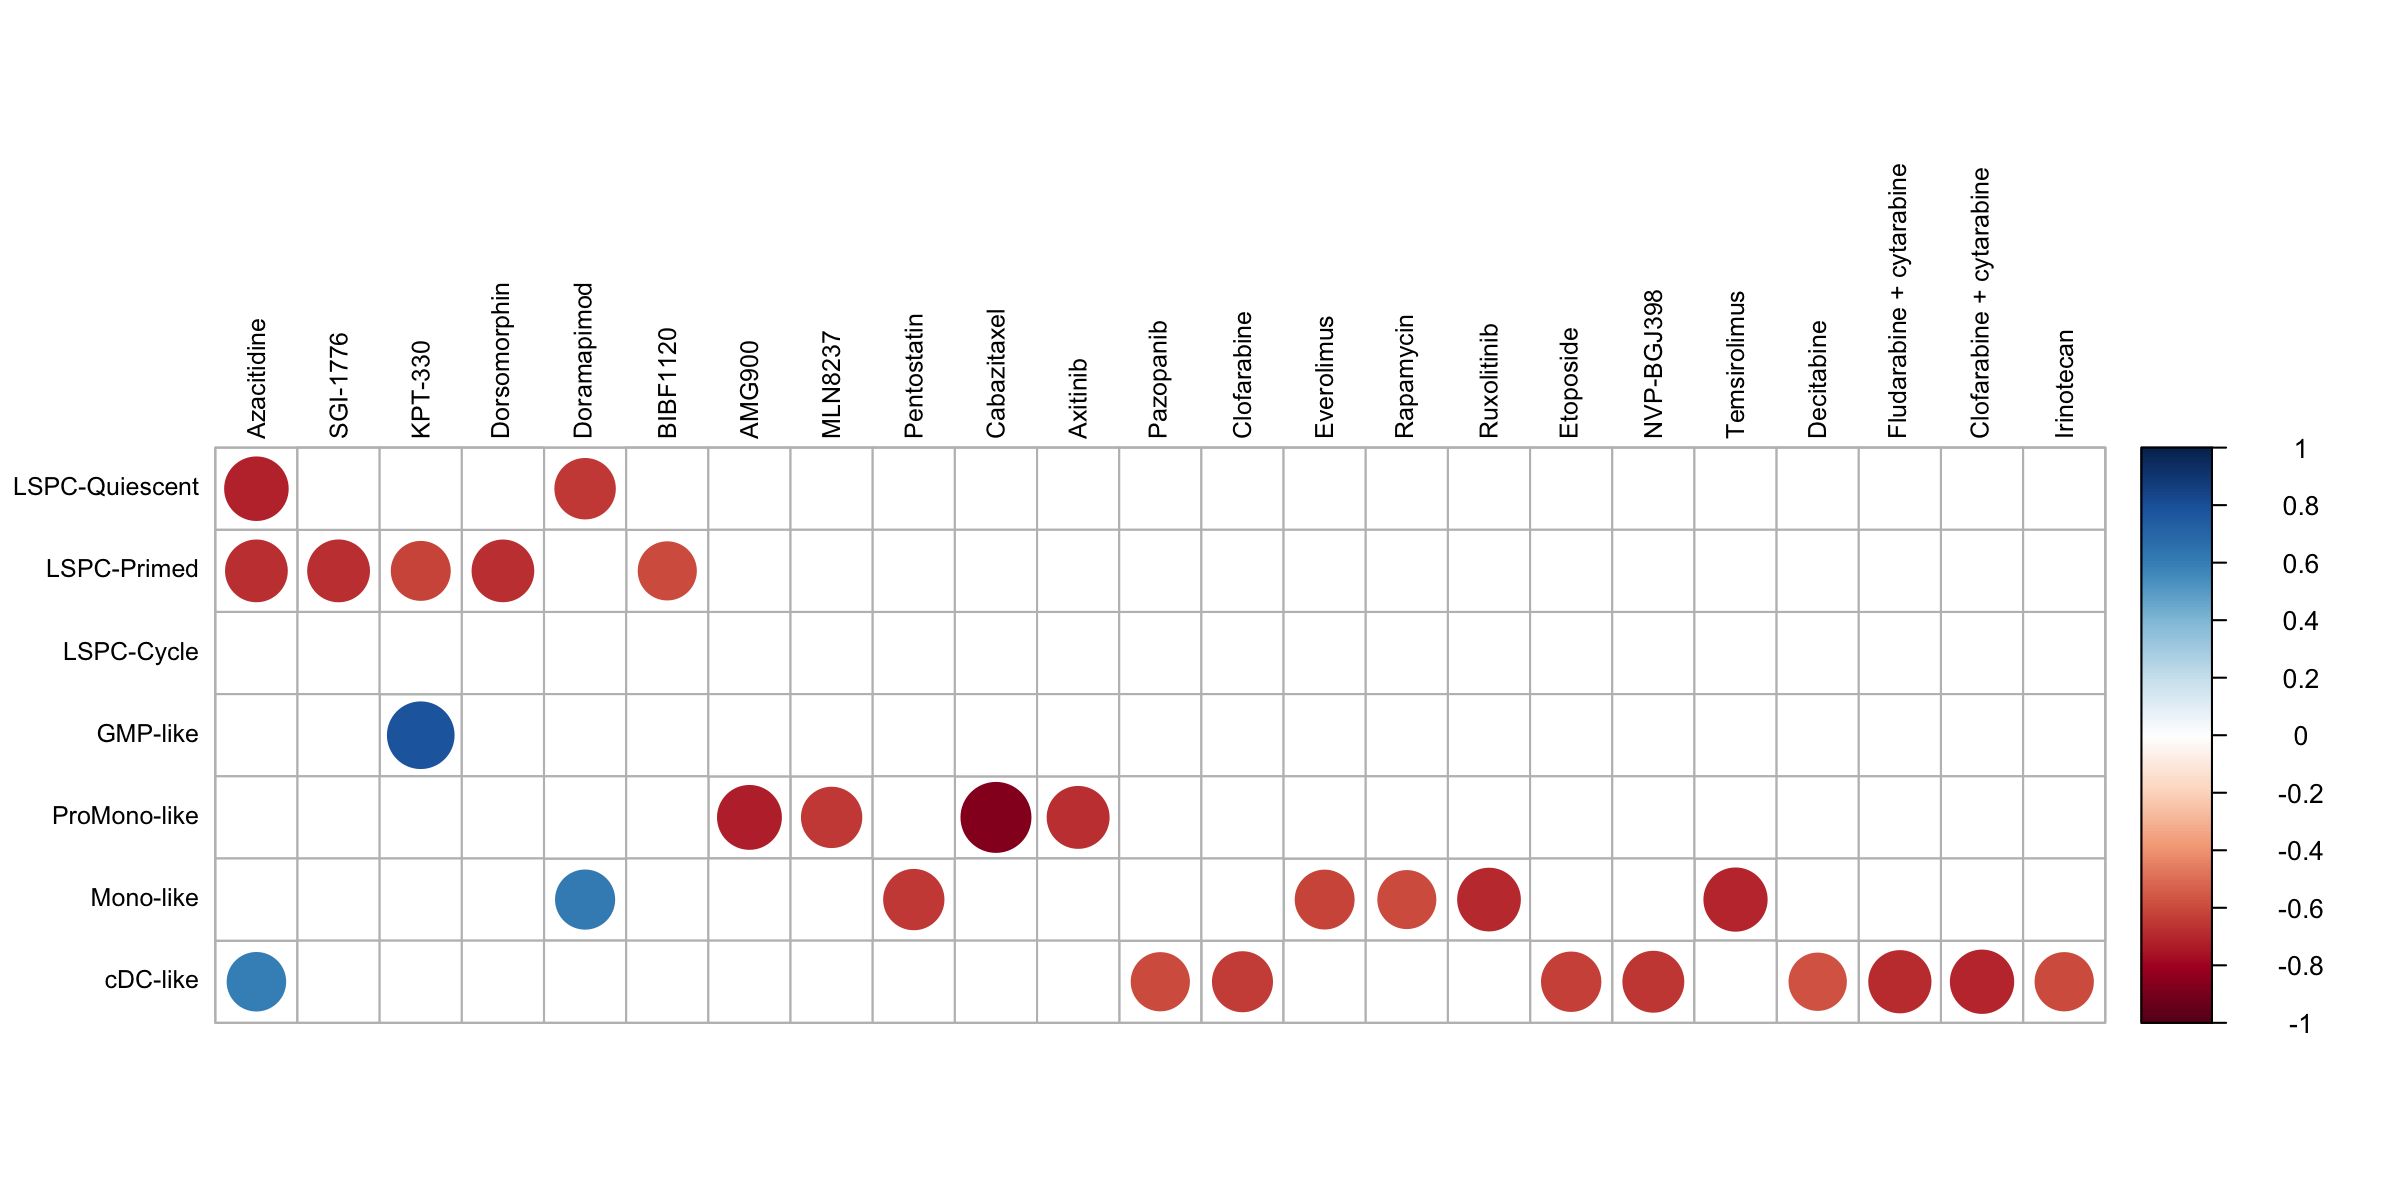

In [39]:
%%R -w 12 -h 6 --units in -r 200 -i relcorr_pearson -i relcorr_logFDR -i relcorr_qvalue -i relcorr_pvalue

library("corrplot")
library(RColorBrewer)

# only show the significant correlations due to the low number of patients 
relcorr_pearson %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.75, p.mat = data.matrix(relcorr_pvalue),
                                        sig.level=0.05, insig = "blank", pch.col = "black", pch.cex = 1, 
                                        is.corr = TRUE, tl.col = 'black') #c("pch", "p-value", "blank", "n", "label_sig"),) 